In [185]:
import pandas as pd
import math
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier,KNeighborsRegressor
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_columns', 500)
pd.set_option('display.float_format', lambda x: '%.1f' % x)

In [225]:
train = pd.read_csv('../data/clean_train_all_cols_chase.csv', parse_dates=['timestamp'], index_col="id")  
test = pd.read_csv('../data/clean_test_all_cols_chase.csv', parse_dates=['timestamp'], index_col="id")

locales = pd.read_csv("../../data/okurg.csv")
locales.okurg_district = locales.okurg_district.apply(lambda x: x.strip())

cols = ['price_doc','timestamp','full_sq','life_sq','kitch_sq','floor',
        'max_floor','build_year','state','num_room','product_type','sub_area','kremlin_km']

df = train.loc[:,cols]
df = pd.merge(df,locales, how="left", on="sub_area").reset_index(drop=True).set_index(df.index)

## Helper Functions

In [226]:
def add_multiples(df):
    """ add/update price multiples and sq ratios. This is just for finding outliers """
    
    # create the columns for price / sq
    price_to_full = df.price_doc / df.full_sq
    df.loc[:,'price_full'] = price_to_full
    df.loc[:,'price_full_std'] = (price_to_full - np.nanmean(price_to_full)) / np.nanstd(price_to_full)
    df.loc[:,'usd_sq_foot'] = df.price_doc / 32 / (df.full_sq * 10.5)

def getKremlinGroup(df, id):
    """ returns the group that are the same distance from the kremlin"""
    x = df.loc[id,'kremlin_km']
    return df.loc[df.kremlin_km==x,:]

In [227]:
df.sub_area = df.sub_area.apply(lambda x: x.replace(" ", "_"))
df.sub_area = df.sub_area.apply(lambda x: x.replace("'", ""))
df.sub_area = df.sub_area.apply(lambda x: x.replace("-", ""))

df.okurg_district = df.okurg_district.apply(lambda x: x.replace(" ", "_"))
df.okurg_district = df.okurg_district.apply(lambda x: x.replace("'", ""))
df.okurg_district = df.okurg_district.apply(lambda x: x.replace("-", ""))

In [228]:
add_multiples(df)

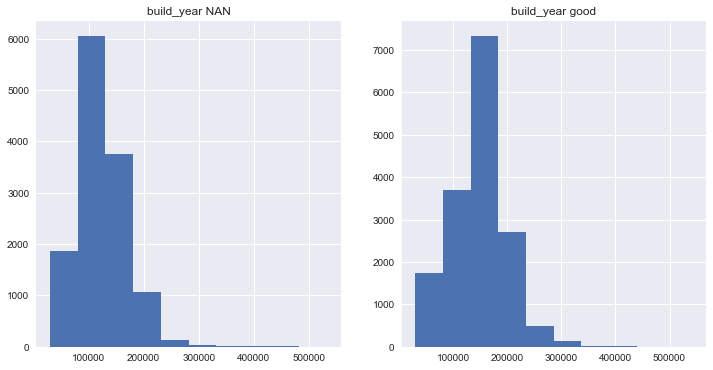

In [229]:
fig, axs = plt.subplots(ncols = 2, figsize=(12,6))
axs[0].set_title('build_year NAN')
axs[1].set_title('build_year good')
df[df.build_year.isnull()].price_full.hist(ax=axs[0])
df[~df.build_year.isnull()].price_full.hist(ax=axs[1])

In [230]:
df.columns

Index([u'price_doc', u'timestamp', u'full_sq', u'life_sq', u'kitch_sq',
       u'floor', u'max_floor', u'build_year', u'state', u'num_room',
       u'product_type', u'sub_area', u'kremlin_km', u'okurg_district',
       u'price_full', u'price_full_std', u'usd_sq_foot'],
      dtype='object')

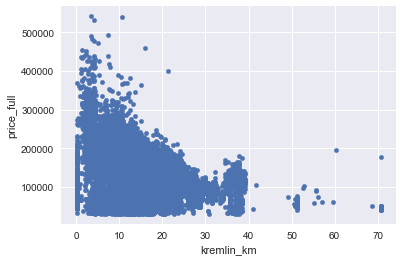

In [231]:
df.plot.scatter(x = 'kremlin_km', y='price_full')

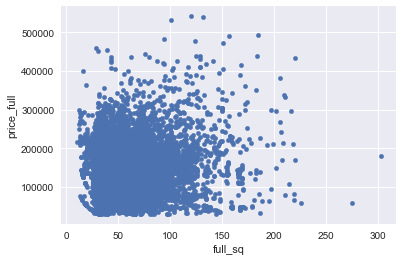

In [232]:
df.plot.scatter(x = 'full_sq', y='price_full')

In [233]:
print df[df.product_type == "Investment"].price_full.median()
print df[df.product_type == "OwnerOccupier"].price_full.median()

156097.560976
100381.553418


UnicodeDecodeError: 'ascii' codec can't decode byte 0xc2 in position 36: ordinal not in range(128)

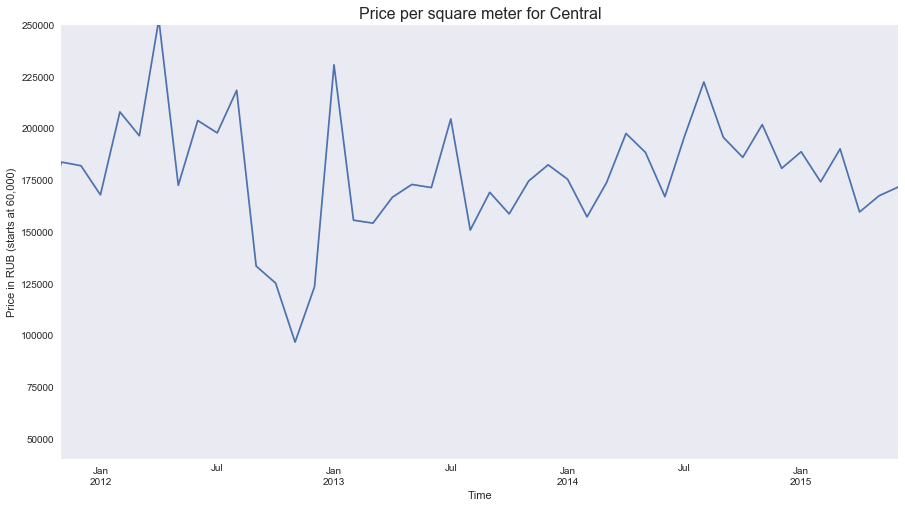

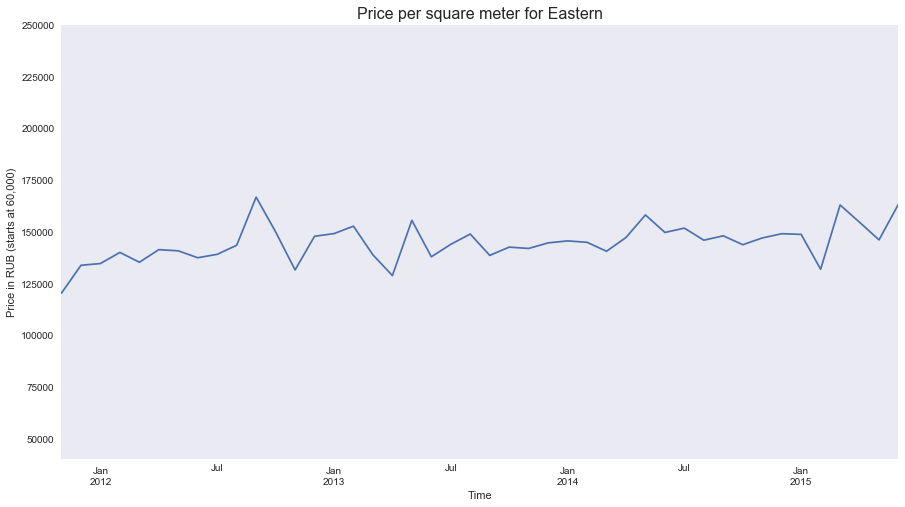

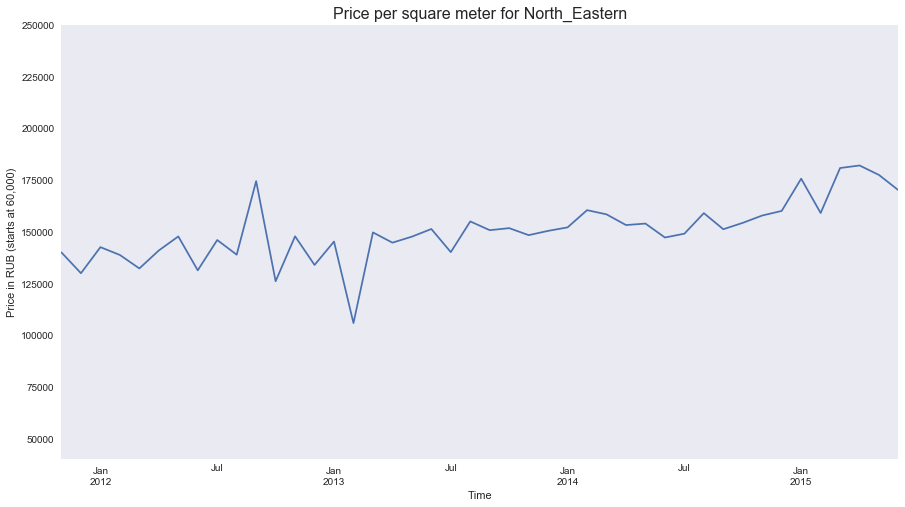

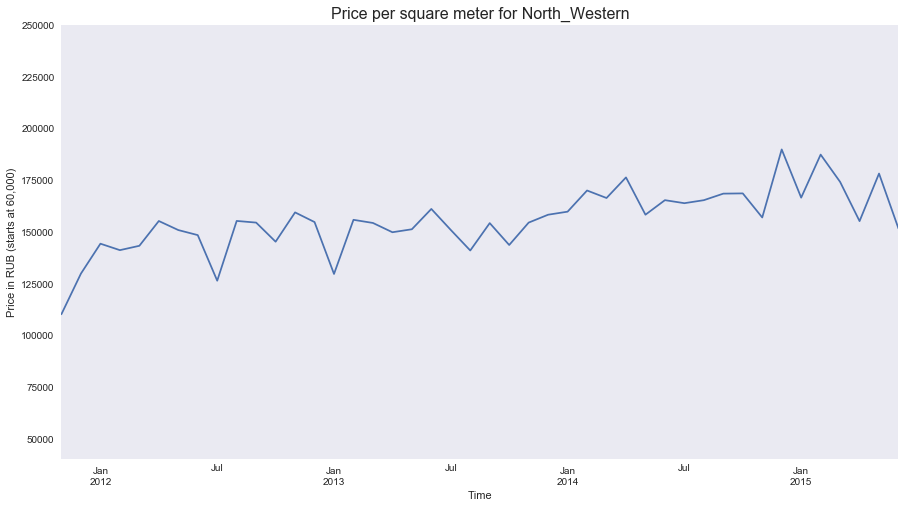

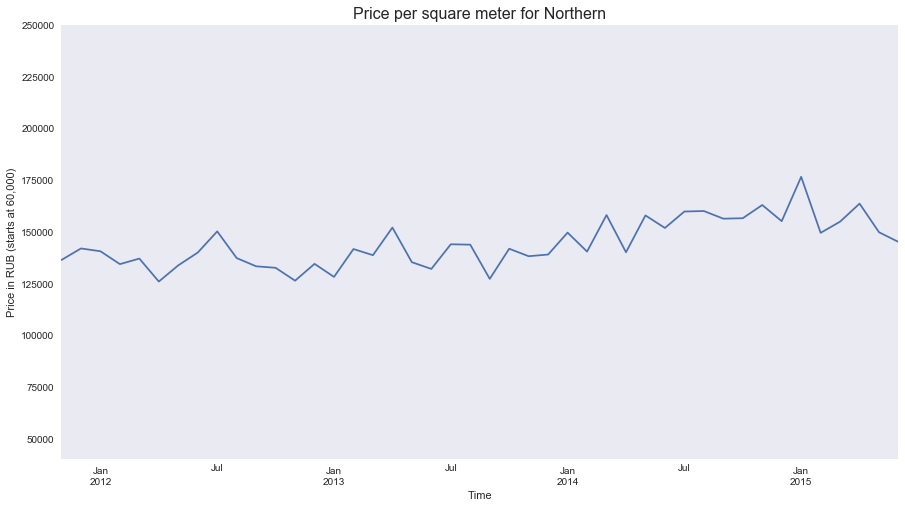

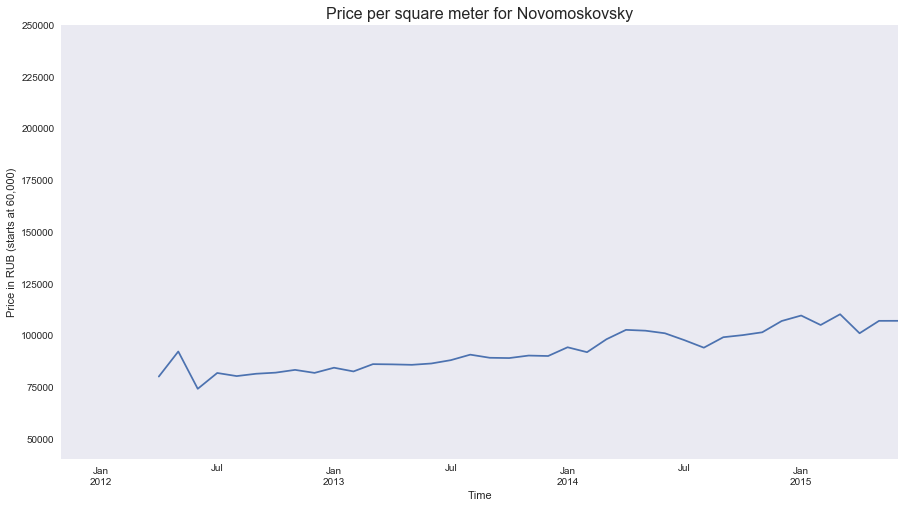

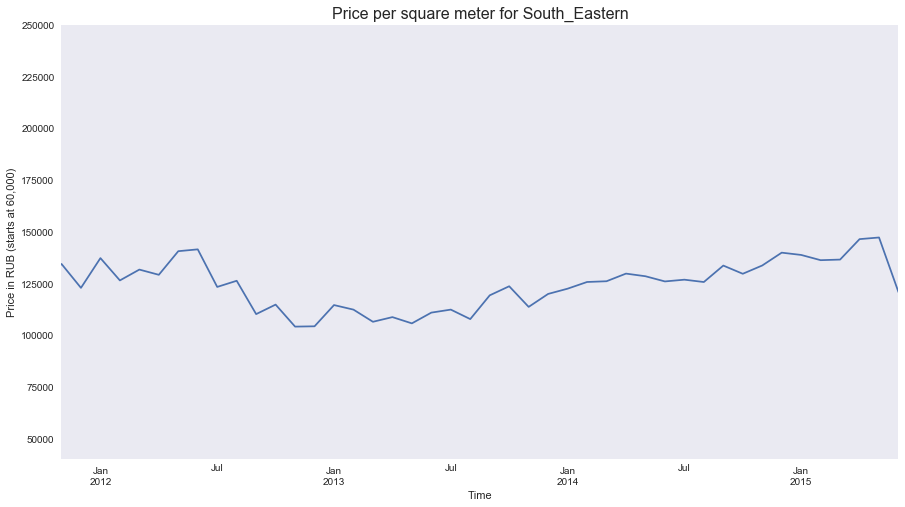

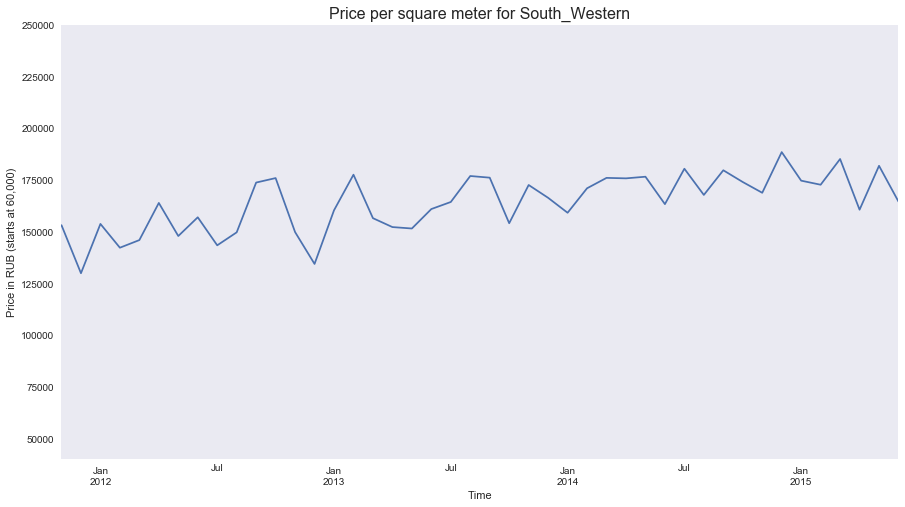

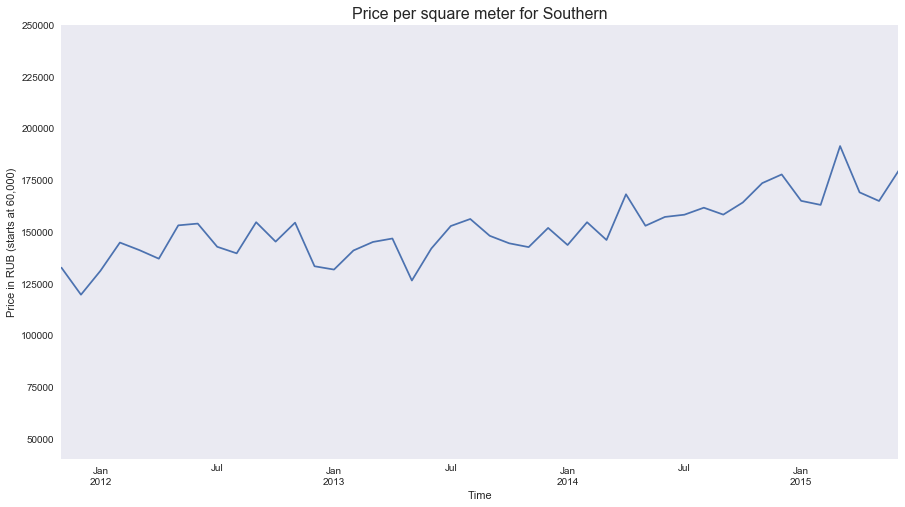

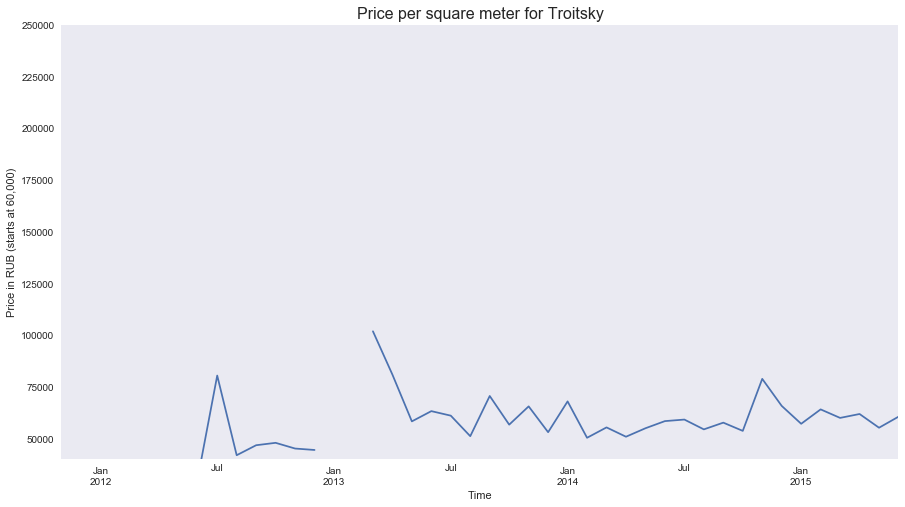

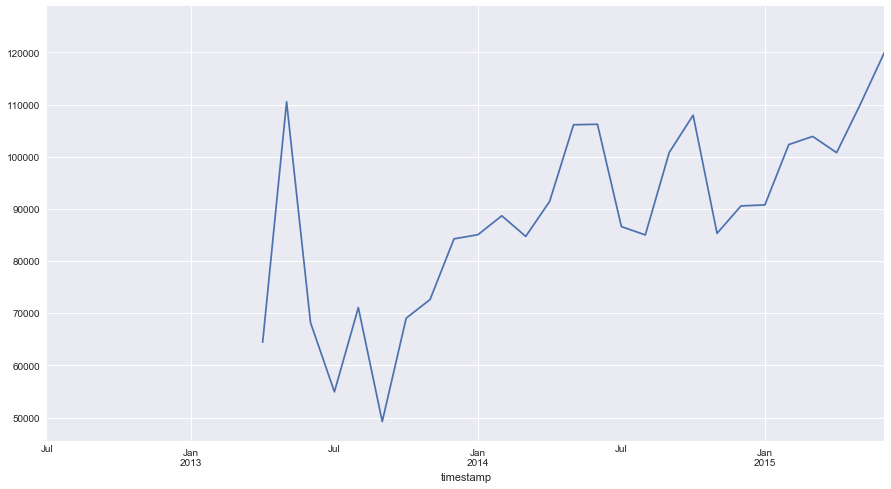

In [234]:
district_groups = df.groupby('okurg_district')
for group in district_groups:
    time_group = group[1].set_index('timestamp').groupby(pd.TimeGrouper(freq='M'))
    plt.figure(figsize=(15,8))
    (time_group['price_doc'].sum() / time_group['full_sq'].sum()).plot()
    plt.title('Price per square meter for {}'.format(group[0]), fontsize=16)
    plt.xlabel('Time')
    plt.ylabel('Price in RUB (starts at 60,000)')
    plt.ylim([40000,250000])
    plt.xlim(['2011-11-01', '2015-06-30'])
    plt.grid()

In [236]:
print district_groups

In [237]:
area_groups = df.groupby('sub_area')